**Main imports**

In [1]:
import os
import math
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import matplotlib.pyplot as plt
from IPython import display as disp

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

**Import dataset**

In [2]:
#helper function to make getting another batch of data easier
def cycle(iterable):
    while True:
        for x in iterable:
            yield x

class_names = ['apple','aquarium_fish','baby','bear','beaver','bed','bee','beetle','bicycle','bottle','bowl','boy','bridge','bus','butterfly','camel','can','castle','caterpillar','cattle','chair','chimpanzee','clock','cloud','cockroach','couch','crab','crocodile','cup','dinosaur','dolphin','elephant','flatfish','forest','fox','girl','hamster','house','kangaroo','computer_keyboard','lamp','lawn_mower','leopard','lion','lizard','lobster','man','maple_tree','motorcycle','mountain','mouse','mushroom','oak_tree','orange','orchid','otter','palm_tree','pear','pickup_truck','pine_tree','plain','plate','poppy','porcupine','possum','rabbit','raccoon','ray','road','rocket','rose','sea','seal','shark','shrew','skunk','skyscraper','snail','snake','spider','squirrel','streetcar','sunflower','sweet_pepper','table','tank','telephone','television','tiger','tractor','train','trout','tulip','turtle','wardrobe','whale','willow_tree','wolf','woman','worm',]

#loading the dataset
train_set = dset.CIFAR100(root="./data", download=True, train=True,
                        transform=transforms.Compose([
                            transforms.ToTensor(),
                            transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
                            #transforms.Normalize(mean=(0.5071, 0.4867, 0.4408), std=(0.2675, 0.2565, 0.2761))
                        ]))
nc=3

test_set = dset.CIFAR100(root="./data", download=True, train=False,
                        transform=transforms.Compose([
                            transforms.ToTensor()
                            #transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
                            #transforms.Normalize(mean=(0.5071, 0.4867, 0.4408), std=(0.2675, 0.2565, 0.2761))
                        ]))

train_loader = torch.utils.data.DataLoader(train_set, batch_size=128, drop_last=True, shuffle=True, num_workers=2)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=128, drop_last=True, shuffle=True, num_workers=2)
train_iterator = iter(cycle(train_loader))
test_iterator = iter(cycle(test_loader))
print(f'> Size of training dataset {len(train_loader.dataset)}')

> Size of training dataset 50000


**View some of the train dataset**

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].


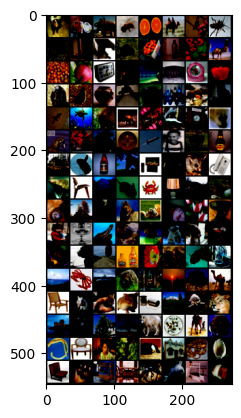

In [3]:
#view some of the training data
plt.rcParams['figure.dpi'] = 100
x,t = next(train_iterator)
x,t = x.to(device), t.to(device)
plt.imshow(torchvision.utils.make_grid(x).cpu().numpy().transpose(1, 2, 0), cmap=plt.cm.binary)
plt.show()

**DCGAN generative model**

In [4]:
#DCGAN code derived from https://pytorch.org/tutorials/beginner/dcgan_faces_tutorial.html

learningRate = 0.0002

ngpu = 1
#size of z latent vector (i.e. size of generator input)
nz = 100
#size of feature maps in generator
ngf = 46
#size of feature maps in discriminator
ndf = 46

#custom weights initialization called on netG and netD
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        m.weight.data.normal_(0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        m.weight.data.normal_(1.0, 0.02)
        m.bias.data.fill_(0)

class Generator(nn.Module):
    def __init__(self, ngpu):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            #input is Z, going into a convolution
            nn.ConvTranspose2d(nz, ngf * 4, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            #state size. (ngf*4) x 4 x 4
            nn.ConvTranspose2d(ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            #state size. (ngf*2) x 8 x 8
            nn.ConvTranspose2d(ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            #state size. (ngf) x 16 x 16
            nn.ConvTranspose2d(ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()
            #state size. (nc) x 32 x 32
        )

    def forward(self, input):
        if input.is_cuda and self.ngpu > 1:
            output = nn.parallel.data_parallel(self.main, input, range(self.ngpu))
        else:
            output = self.main(input)
        return output

#create the generator
netG = Generator(ngpu).to(device)
#apply the ``weights_init`` function to randomly initialize all weights to ``mean=0``, ``stdev=0.02``.
netG.apply(weights_init)
print(netG)

class Discriminator(nn.Module):
    def __init__(self, ngpu):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            #input is (nc) x 32 x 32
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            #state size. (ndf) x 16 x 16
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            #state size. (ndf*2) x 8 x 8
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            #state size. (ndf*4) x 4 x 4
            nn.Conv2d(ndf * 4, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        if input.is_cuda and self.ngpu > 1:
            output = nn.parallel.data_parallel(self.main, input, range(self.ngpu))
        else:
            output = self.main(input)
        return output.view(-1, 1).squeeze(1)

#create the Discriminator
netD = Discriminator(ngpu).to(device)
#apply the ``weights_init`` function to randomly initialize all weights
#like this: ``to mean=0, stdev=0.2``.
netD.apply(weights_init)
print(netD)

criterion = nn.BCELoss()

#setup optimiser
optimizerD = optim.Adam(netD.parameters(), lr=learningRate, betas=(0.5, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=learningRate, betas=(0.5, 0.999))

fixed_noise = torch.randn(64, nz, 1, 1, device=device)
real_label = 1
fake_label = 0

#print the number of parameters
print(f'> Number of generator parameters {len(torch.nn.utils.parameters_to_vector(netG.parameters()))}')
print(f'> Number of discriminator parameters {len(torch.nn.utils.parameters_to_vector(netD.parameters()))}')

if len(torch.nn.utils.parameters_to_vector(netG.parameters())) + len(torch.nn.utils.parameters_to_vector(netD.parameters())) > 1000000:
    print("> Warning: you have gone over your parameter budget and will have a grade penalty!")

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 184, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(184, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(184, 92, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(92, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(92, 46, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(46, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(46, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): Tanh()
  )
)
Discriminator(
  (main): Sequential(
    (0): Conv2d(3, 46, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(46, 92, kernel_size=(4, 4), st

**Main training loop**

[49000/50000] Loss_D: 0.2020 Loss_G: 3.5182 D(x): 0.9372 D(G(z)): 0.1138 / 0.0520


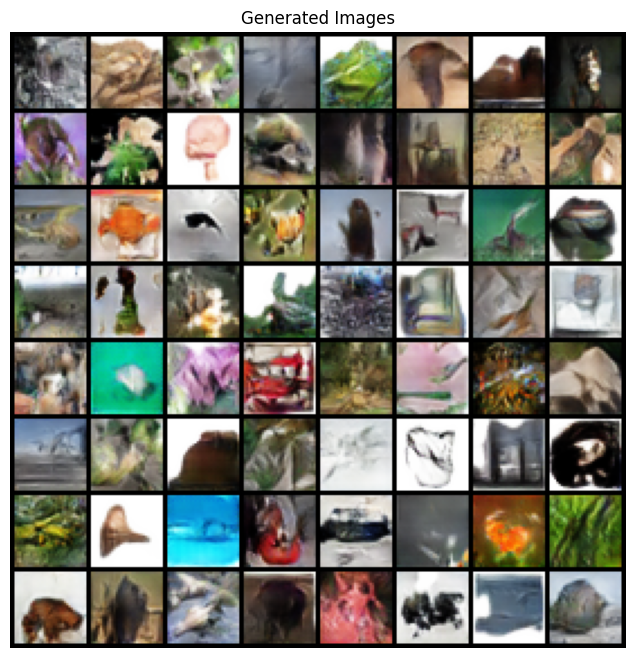

In [5]:
checkpoint_dir = "model_checkpoints" 
image_dir = "generated_images"
os.makedirs(checkpoint_dir, exist_ok=True)
os.makedirs(image_dir, exist_ok=True)

steps = 0
max_steps = 50000
g_loss = []
d_loss = []

print("Starting Training Loop...")

#keep within our optimisation step budget
while steps < max_steps:
    for i, data in enumerate(train_loader, 0):
        if steps >= max_steps:
            break

        ############################
        # update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        netD.zero_grad()
        #format batch
        real_cpu = data[0].to(device)
        batch_size = real_cpu.size(0)
        label = torch.full((batch_size,), real_label, dtype=torch.float, device=device)
        
        #forward pass real batch through D
        output = netD(real_cpu).view(-1)
        #calculate loss on all-real batch
        errD_real = criterion(output, label)
        errD_real.backward()
        D_x = output.mean().item()

        #generate batch of latent vectors
        noise = torch.randn(batch_size, nz, 1, 1, device=device)
        #generate fake image batch with G
        fake = netG(noise)
        label.fill_(fake_label)
        #classify all fake batch with D
        output = netD(fake.detach()).view(-1)
        #calculate D's loss on the all-fake batch
        errD_fake = criterion(output, label)
        errD_fake.backward()
        D_G_z1 = output.mean().item()

        #compute error of D as sum over the fake and the real batches
        errD = errD_real + errD_fake
        optimizerD.step()

        ############################
        # update G network: maximize log(D(G(z)))
        ###########################
        netG.zero_grad()
        label.fill_(real_label) 
        #forward pass fake batch through D
        output = netD(fake).view(-1)
        #calculate G's loss based on this output
        errG = criterion(output, label)
        errG.backward()
        D_G_z2 = output.mean().item()

        #update G
        optimizerG.step()

        #save losses for plotting
        g_loss.append(errG.item())
        d_loss.append(errD.item())
        if steps % 1000 == 0:
            disp.clear_output(wait=True)
            print(f"[{steps}/{max_steps}] Loss_D: {errD.item():.4f} Loss_G: {errG.item():.4f} D(x): {D_x:.4f} D(G(z)): {D_G_z1:.4f} / {D_G_z2:.4f}")

            netG.eval()
            with torch.no_grad():
                #generate images form noise
                fake = netG(fixed_noise).detach().cpu()
            #create a grid of images
            plt.figure(figsize=(8, 8))
            plt.axis("off")
            plt.title("Generated Images")
            plt.imshow(np.transpose(vutils.make_grid(fake, padding=2, normalize=True), (1, 2, 0)))
            plt.savefig(os.path.join(image_dir, f"step_{steps}.png"))
            plt.show()
            netG.train()

            #save the generator state
            torch.save(netG.state_dict(), os.path.join(checkpoint_dir, f"generator_step_{steps}.pth"))

        steps += 1

**Latent interpolations**

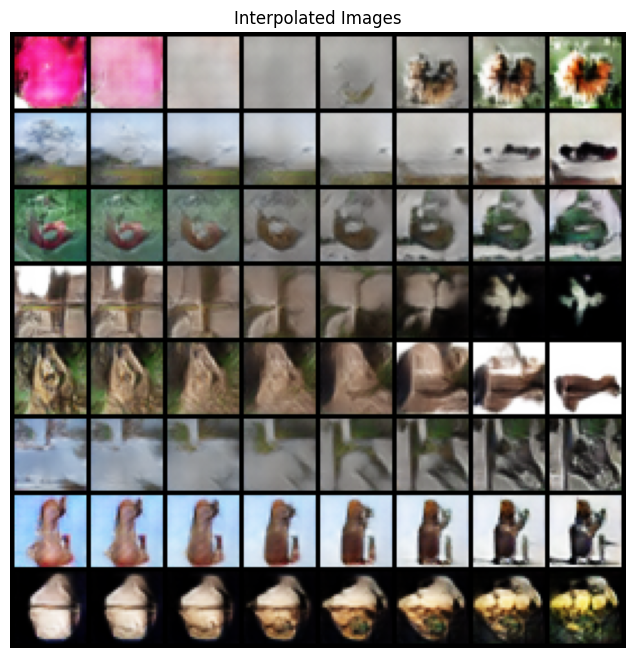

In [26]:
model_path = 'model_checkpoints/generator_step_49000.pth'  #adjust path as necessary
netG.load_state_dict(torch.load(model_path))
netG.eval()

def interpolate_points(p1, p2, n_steps=8):
    p1 = p1.view(1, -1, 1, 1)
    p2 = p2.view(1, -1, 1, 1)
    ratios = torch.linspace(0, 1, steps=n_steps, device=p1.device)
    vectors = (1.0 - ratios)[:, None, None, None] * p1 + ratios[:, None, None, None] * p2
    return vectors

def generate_interpolated_vectors(num_sets=8, n_steps=8, latent_dim=100, device='cuda'):
    all_interpolated_vectors = []
    for _ in range(num_sets):
        p1 = torch.randn(latent_dim, device=device) 
        p2 = torch.randn(latent_dim, device=device)  
        #interpolate between p1 and p2
        vectors = interpolate_points(p1, p2, n_steps)
        all_interpolated_vectors.append(vectors)
    
    interpolated_vectors = torch.cat(all_interpolated_vectors, dim=0)
    return interpolated_vectors


interpolated_vectors = generate_interpolated_vectors(num_sets=8, n_steps=8, latent_dim=nz, device=device)

interpolated_images = netG(interpolated_vectors).detach().cpu()

#normalise images from [-1, 1] to [0, 1]
normalized_images = (interpolated_images + 1) / 2

#ensure images don't fall outside the bounds
normalized_images = normalized_images.clamp(0, 1)

plt.figure(figsize=(8, 8))
plt.axis("off")
plt.title("Interpolated Images")
plt.imshow(np.transpose(vutils.make_grid(normalized_images, padding=2, normalize=False), (1, 2, 0)))
save_path = "interpolated_images.png"
plt.savefig(save_path, bbox_inches='tight')
plt.show()

**FID scores**

Evaluate the FID from 10k of your model samples (do not sample more than this) and compare it against the 10k test images. Calculating FID is somewhat involved, so we use a library for it. It can take a few minutes to evaluate. Lower FID scores are better.

In [28]:
%%capture
!pip install clean-fid
!pip install shutil
import os
from cleanfid import fid
from torchvision.utils import save_image
import shutil

In [29]:
real_images_dir = 'real_images'
generated_images_dir = 'generated_images'
num_samples = 10000

def setup_directory(directory):
    if os.path.exists(directory):
        shutil.rmtree(directory)
    os.makedirs(directory)

setup_directory(real_images_dir)
setup_directory(generated_images_dir)

#generate and save 10k model samples
num_generated = 0
while num_generated < num_samples:

    #sample from model
    noise = torch.randn(1, 100, 1, 1, device=device)
    with torch.no_grad():
        fake_image = netG(noise)
    
    #normalise image from [-1, 1] to [0, 1]
    fake_image = (fake_image + 1) / 2
    fake_image = fake_image.clamp(0, 1)
    
    save_path = os.path.join(generated_images_dir, f'image_{num_generated:05d}.png')
    vutils.save_image(fake_image, save_path)
    num_generated += 1

#save 10k images from CIFAR-1000
num_saved_real = 0
while num_saved_real < num_samples:
    real_samples_batch, _ = next(test_iterator)
    for image in real_samples_batch:
        if num_saved_real >= num_samples:
            break

        vutils.save_image(image, os.path.join(real_images_dir, f"real_img_{num_saved_real}.png"))
        num_saved_real += 1

In [30]:
#compute FID
score = fid.compute_fid(real_images_dir, generated_images_dir, mode="clean", num_workers=0)
print(f"FID score: {score}")

compute FID between two folders
Found 20000 images in the folder real_images


FID real_images : 100%|██████████| 625/625 [02:51<00:00,  3.64it/s]


Found 20000 images in the folder generated_images


FID generated_images : 100%|██████████| 625/625 [02:44<00:00,  3.79it/s]


FID score: 47.25712530922766
